In [1]:
import os
import fitsio
import desimodel
import astropy
import pandas                as     pd
import pylab                 as     pl
import numpy                 as     np
import astropy.io.fits       as     fits
import matplotlib.pyplot     as     plt

from   datetime              import datetime
from   astropy.table         import Table, vstack, join
from   astropy.coordinates   import Angle, SkyCoord
from   astropy               import units as u

from   desimodel.footprint   import is_point_in_desi
from   desimodel             import io
from   desitarget.geomask    import circles
from   desitarget.targetmask import desi_mask, obsconditions
from   astropy.coordinates   import SkyCoord
from   astropy.table         import Table
from   pathlib               import Path
from   desimodel.focalplane  import get_tile_radius_deg

In [2]:
np.random.seed(seed=314)

Potential addition: 'Stars were removed from the sample used to compute the number counts using SExtractor’s CLASS_STAR parameter with a threshold of 0.85'

In [3]:
def get_hildebrandt(field='D2'):
    # SXDS:  (02:18:00.00, −05:00:00.00), D1 encompassed by W1.  
    return  Table.read('/global/cscratch1/sd/mjwilson/DESILBG/Hildebrandt/{}.cat'.format(field))

In [4]:
def get_goldrush():
    # https://arxiv.org/pdf/1704.06004.pdf    
    return Table.read('/global/homes/m/mjwilson/DESILBG/target/proposals/goldrush/goldrush_mizukizs.fits')

In [5]:
def get_laes():
    # https://arxiv.org/pdf/0801.4017.pdf
    dat   = pd.read_csv('/global/homes/m/mjwilson/DESILBG/target/proposals/sxds_laes.txt', sep='\s+', comment='#')
    
    dat.drop(dat.columns[list(np.arange(7, 20, 1))], axis=1, inplace=True)
    
    dat.columns = ['Row', 'Name', 'RA', 'DEC', 'None', 'Velocity', 'Redshift']
    dat['RA']   = [Angle(x).deg for x in dat['RA']]
    dat['DEC']  = [Angle(x[:-1] + '.0s').deg for x in dat['DEC']]
    
    return  dat

In [6]:
def get_vvds():
    # https://cesam.lam.fr/vvds/vvds_download.php
    dat = pd.read_csv('/global/cscratch1/sd/mjwilson/VVDS/cesam_vvds_spF02_DEEP_Full.txt', sep='\s+')

    # Cut.
    dat = dat[dat['Z'] < 9.0]
    
    return dat

In [7]:
def get_splash():
    dat = Table.read('/global/cscratch1/sd/mjwilson/SPLASH/SPLASH_SXDF_Mehta+_v1.6.fits')
    
    return dat

In [9]:
def get_clauds(imaging_bit=1, field='COSMOS', release='March2021'):
    fields           = ['COSMOS', 'DEEP_2', 'ELAIS', 'XMM_LSS']
    clauds           = {}
        
    assert field in fields
        
    areas            = {}
    areas['COSMOS']  = {'u': 4.41, 'uS': 4.20, 'g': 7.84,  'r': 7.84,  'i': 7.84,  'z': 7.84,  'y': 7.84}
    areas['XMM-LSS'] = {'u': 0.00, 'uS': 6.80, 'g': 6.38,  'r': 6.38,  'i': 6.38,  'z': 6.38,  'y': 6.38}
    areas['DEEP2-3'] = {'u': 3.70, 'uS': 0.00, 'g': 6.11,  'r': 6.11,  'i': 6.11,  'z': 6.11,  'y': 6.11}
    areas['ELAIS-N'] = {'u': 6.49, 'uS': 0.00, 'g': 10.68, 'r': 10.68, 'i': 10.68, 'z': 10.68, 'y': 10.68}

    for key in areas.keys():
        if imaging_bit == 1:
            del areas[key]['uS']
    
        elif imaging_bit == 2:
            del areas[key]['u']

    if release == 'October2020':
        raise NotImplementedError()
        
    elif release == 'February2021':
        clauds[field] = Table.read('/global/cscratch1/sd/mjwilson/clauds/{}/{}_v9_v210212.fits'.format(release, field))
        
    else:
        clauds[field] = Table.read('/global/cscratch1/sd/mjwilson/clauds/{}/{}_v9_v210225.fits'.format(release, field))
    
    # Bright star mask & has newer u band data: [HSC, u, Us, J, VirCAM, UDEEP] for FLAG_FIELD_BINARY (imaging_bit). 
    clauds[field] = clauds[field][(clauds[field]['MASK'] == 0) & clauds[field]['FLAG_FIELD_BINARY'][:,imaging_bit] == True]

    # Randomise the rows for security. 
    indices       = np.arange(len(clauds[field]))
    randomised    = np.random.choice(indices, size=len(indices), replace=False)
    
    return  clauds[field][randomised], areas[field]

In [10]:
def get_cfhtls_wide():
    # https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/megapipe/cfhtls/uc.html; I-band detected. 
    # u-band limit of 25.2 in the wide field.
    filename = '/global/cscratch1/sd/mjwilson/CFHTLS/W.I.con.cat'     
    
    names    = []

    with open(filename, 'r') as fh:
      for curline in fh:
         if curline.startswith("#"):
              words = curline.split()
              names.append(words[2])

         else:
            break
    
    fh.close()
    
    dat   = pd.read_csv(filename, sep='\s+', comment='#', names=names)
                        
    return  dat

In [11]:
tile_radius = get_tile_radius_deg()
tiles       = Table(io.load_tiles())

In [11]:
# hiz  = laigle()

In [12]:
# kids = get_kids()

In [13]:
# splash = get_splash()

In [14]:
# splash_zspec = splash[splash['ZSPEC'] > 0.]

In [15]:
# hilde  = get_hildebrandt()

In [16]:
# grush  = get_goldrush()

In [17]:
# laes   = get_laes()

In [18]:
# cfhtls = get_cfhtls_wide()

In [19]:
# vvds = get_vvds()

In [12]:
clauds, area = get_clauds(imaging_bit=1, field='COSMOS')

In [13]:
# Old length: 2582606, 2757450, 
clauds

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [7],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,FUV,NUV,u,uS,g,r,i,z,y,Yv,J,H,Ks,FUV_err,NUV_err,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,MAG_APER_3s_u,MAG_APER_3s_uS,MAG_APER_3s_g,MAG_APER_3s_r,MAG_APER_3s_i,MAG_APER_3s_z,MAG_APER_3s_y,MAG_APER_3s_Yv,MAG_APER_3s_J,MAG_APER_3s_H,MAG_APER_3s_Ks,MAGERR_APER_3s_u,MAGERR_APER_3s_uS,MAGERR_APER_3s_g,MAGERR_APER_3s_r,MAGERR_APER_3s_i,MAGERR_APER_3s_z,MAGERR_APER_3s_y,MAGERR_APER_3s_Yv,MAGERR_APER_3s_J,MAGERR_APER_3s_H,MAGERR_APER_3s_Ks,OFFSET_MAG_2s,OFFSET_MAG_3s,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,Z_BC03,ZPHOT,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,STAR_FORMING,NrK,IRX_NrK,LIR_NrK,SFR_NrK,VMAX_uS,VMAX_g,VMAX_r,VMAX_i,VMAX_Ks
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3154335,149.13232433290514,2.5546504606039897,9812,"2,6",0,7,True .. False,6.432973e-05,4.1858057e-05,4.0,65.04344,1.5367969,0.34929597,0.019528131582531447,0.00024061684,25.891245,0.356922,1.0085294,1.4280493,1.7852052,-99.0,-99.0,-99.094,28.809,29.315,27.493,26.726,27.176,27.869,-99.024,-99.017,-99.011,-99.007,-99.0,-99.0,-99.0,1.811,1.439,0.368,0.235,0.554,2.562,1000.0,1000.0,1000.0,1000.0,99.0,28.899778,29.386625,27.545229,26.76477,27.20536,27.893911,-99.0,-99.0,-99.0,-99.0,-99.0,1.8105469,1.4394531,0.36767578,0.23498535,0.5541992,2.5625,1000.0,1000.0,1000.0,1000.0,99.0,99.0,99.0,29.40419,26.695395,28.843664,99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,3.0585938,0.3310547,3.7519531,-99.0,1000.0,1000.0,1000.0,1000.0,0.0,-1.666145738744851,2046.0,-18.286,-17.828,-144.694,-144.851,-144.744,-145.078,-145.358,-145.578,-145.693,-145.729,-145.855,-146.046,-145.886,-99.0,4.4438,0.1329,4.787,10,0.495874,1.32878,0.527892,33,96,18,3.2816,0.6334,4.3225,0.26,3.36,3.2816,3.2816,7,180529000.0,0.4,1,499925000.0,9.67309,9.59731,8.88242,10.515,1.19656,1.46308,0.542404,1.98557,-8.47592,-8.13423

In [154]:
print('Target density of clauds galaxies per sq. deg. is {:.2f}'.format(len(clauds) / area['u']))

Target density of clauds galaxies per sq. deg. is 625272.11


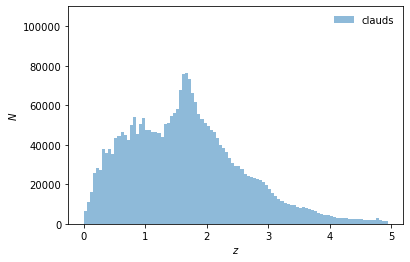

In [155]:
bins = np.arange(0.0, 5.0, 0.05)

pl.hist(clauds['Z_BC03'], bins=bins, alpha=0.5, label='clauds')

pl.ylim(0.0, 1.1e5)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$')

pl.legend(frameon=False)

In [156]:
isin, indx = is_point_in_desi(tiles, clauds['RA'], clauds['DEC'], radius=None, return_tile_index=True)

In [157]:
tileids = np.unique(indx)

In [158]:
tileids

array([  828,  2826,  3754,  5656,  5752,  5753,  7750, 11747, 13744,
       13745])

In [159]:
# u-band imaging restricted.
cra      = np.median(clauds['RA'])
cdec     = np.median(clauds['DEC'])

trad     = tile_radius

In [160]:
# (10:00:59.50, 02:13:53.06)
hsc_cosmos = SkyCoord('10h00m59.5s', '+02d13m53.06s', frame='icrs')

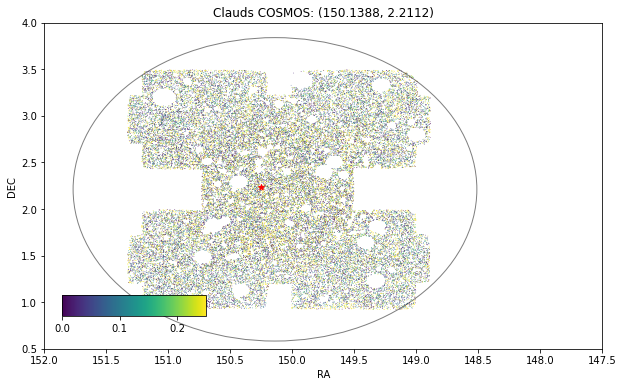

In [161]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 6)) 
im       = pl.scatter(clauds['RA'][::50], clauds['DEC'][::50], c=clauds['u_err'][::50], marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25)

pl.scatter(hsc_cosmos.ra.deg, hsc_cosmos.dec.deg, marker='*', c='r')

circles(cra, cdec, trad, c='k', fc="None", alpha=0.5)
        
ax.set_xlim(152., 147.5)
ax.set_ylim( 0.5,   4.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

cax      = fig.add_axes([0.15, 0.2, 0.2, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')

ax.set_title('Clauds COSMOS: ({:.4f}, {:.4f})'.format(cra, cdec))

pl.savefig('plots/clauds_field.pdf')

In [165]:
def liu_udrops(clauds, band='r', magmin=0.0, maglim=35.):
    '''
    u-drop color selection.
    '''

    # Check these targets have u band imaging available. 
    assert  np.all(clauds['FLAG_FIELD_BINARY'][:,1] == True)
    
    isin = clauds['g'] - clauds['r'] < 1.2
    
    isin = isin & (clauds['u'] - clauds['g'] > 0.88)
    isin = isin & (clauds['u'] - clauds['g'] > 1.99 * (clauds['g'] - clauds['r']) + 0.68)

    isin = isin & (clauds[band] < maglim)
    isin = isin & (clauds[band] > magmin)
    
    # Catch -99 for ill defined magnitudes
    isin = isin & (clauds['u'] > 0.0)
    isin = isin & (clauds['g'] > 0.0)
    isin = isin & (clauds['r'] > 0.0)
    
    return  isin

In [24]:
def hilde_usdrops(clauds, band='r', magmin=0.0, maglim=35.):
    '''
    uS-drop color selection.
    '''
    
    # Check these targets have uS band imaging available.
    assert  np.all(clauds['FLAG_FIELD_BINARY'][:,2] == True)
    
    isin = clauds['g'] - clauds['r'] < 1.2
    isin = isin & (clauds['uS'] - clauds['g'] > 0.90)
    isin = isin & (clauds['uS'] - clauds['g'] > 1.50 * (clauds['g'] - clauds['r']) + 0.75)
    isin = isin & (clauds[band] < maglim)
    isin = isin & (clauds[band] > magmin)
    
    return  isin

In [166]:
udrops = clauds[liu_udrops(clauds)]

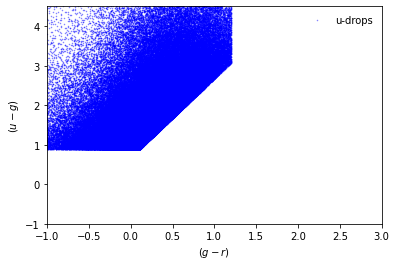

In [169]:
pl.plot(udrops['g'] - udrops['r'], udrops['u'] - udrops['g'], marker='.', c='b', lw=0.0, label='u-drops', alpha=0.5, markersize=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

pl.legend(frameon=False)

pl.savefig('plots/Feb21/clauds-udrop-color-selection.pdf')

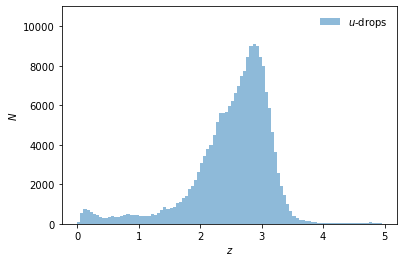

In [171]:
bins = np.arange(0.0, 5.0, 0.05)

pl.hist(udrops['Z_BC03'], bins=bins, alpha=0.5, label='$u$-drops')

pl.ylim(0.0, 1.1e4)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$')

pl.legend(frameon=False)

In [172]:
zmax       = 1.0

interloper = udrops[udrops['Z_BEST'] < zmax]
highz      = udrops[udrops['Z_BEST'] > zmax]

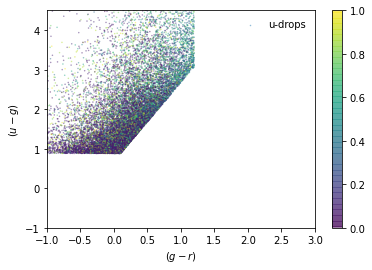

In [173]:
pl.scatter(interloper['g'] - interloper['r'], interloper['u'] - interloper['g'], marker='.', c=interloper['Z_BEST'], alpha=0.5, label='u-drops', vmin=0.0, vmax=zmax, s=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

pl.colorbar()

pl.legend(frameon=False)

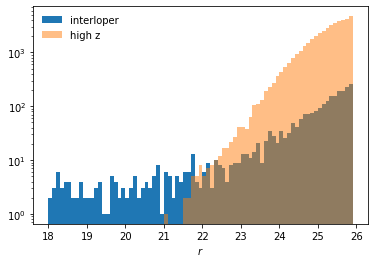

In [174]:
bins = np.arange(18., 26., 0.1)

pl.hist(interloper['r'], bins=bins, label='interloper')
pl.hist(     highz['r'], bins=bins, alpha=0.5, label='high z')

pl.yscale('log')
pl.xlabel(r'$r$')

pl.legend(frameon=False)

In [175]:
rlim_udrops = clauds[liu_udrops(clauds, band='r', magmin=19., maglim=24.5)]

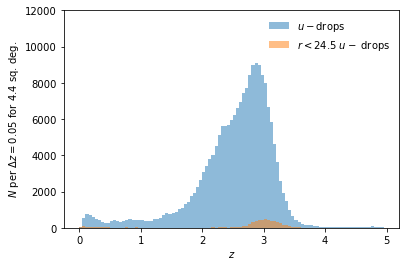

In [176]:
dz          = 0.05
bins        = np.arange(0.0, 5.0, dz)

pl.hist(udrops['Z_BC03'], bins=bins, alpha=0.5, label=r'$u-$drops')
pl.hist(rlim_udrops['Z_BC03'], bins=bins, alpha=0.5, label=r'$r<24.5$ $u-$ drops')

pl.ylim(0.0, 1.2e4)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$ per $\Delta z={:.2f}$ for {:.1f} sq. deg.'.format(dz, area['u']))

pl.legend(frameon=False)

pl.savefig('plots/Feb21/clauds-udrop-redshift-distribution.pdf')

In [177]:
print('Target density of u-dropouts per sq. deg. is {:.2f}'.format(len(rlim_udrops) / area['u']))

Target density of u-dropouts per sq. deg. is 1278.23


In [178]:
print('u-dropout interloper percentage of {:.3f}'.format(100. * np.count_nonzero(rlim_udrops['Z_BC03'] < 1.5) / len(rlim_udrops)))

u-dropout interloper percentage of 11.212


In [36]:
def flatmagcat(maglimcat, band, maglim=24.51, debug=False):
    bins       = np.arange(20., maglim, 0.1)
    
    assert  maglimcat[band].max() <= maglim
    
    result     = np.histogram(maglimcat[band], bins=bins)

    cnts, bins = result[0], result[1]
    lims       = bins[:-1]
     
    cut        = cnts > 0.25 * np.median(cnts[cnts > 0])
    cutlim     = lims[cut][0]
        
    magsampling                    = cnts / cnts[cut][0]    
    magsampling[(magsampling < 1.) & (bins[:-1] < cutlim)] = 1.0
    
    if debug:
        print(magsampling)
    
    magsampling                = 1. / magsampling
        
    magsampling                = np.concatenate((magsampling, np.array([0])))
        
    indx                       = np.digitize(maglimcat[band], bins)
    
    sampling                   = np.random.uniform(0.0, 1.0, len(maglimcat))
    
    maglimcat['ISIN']          = sampling < magsampling[indx]
        
    # In, residual.
    return  cutlim, maglimcat[maglimcat['ISIN']], maglimcat[~maglimcat['ISIN']]

In [37]:
def qa(tiers, band, area):
    upriority, cnts = np.unique(tiers['PRIORITY'].data, return_counts=True)

    for p, c in zip(upriority[::-1], cnts[::-1]):
        magmin      = tiers[tiers['PRIORITY'] == p][band].min()
        
        meanmag     = np.mean(tiers[tiers['PRIORITY'] == p][band])
        meanz       = np.mean(tiers[tiers['PRIORITY'] == p]['Z_BEST'])
        
        quarter     = np.percentile(tiers[tiers['PRIORITY'] == p]['Z_BEST'].compressed(), 25, axis=0)
        medianz     = np.median(tiers[tiers['PRIORITY'] == p]['Z_BEST'].compressed())
        tquarter    = np.percentile(tiers[tiers['PRIORITY'] == p]['Z_BEST'].compressed(), 75, axis=0)   
        
        loper_rate  = 100. * np.count_nonzero(tiers[tiers['PRIORITY'] == p]['Z_BEST'] < 1.5) / len(tiers[tiers['PRIORITY'] == p]) 
        
        print('{: 10d} \t {: .1f} per sq. deg. \t {:.2f} \t {:.2f} \t {:.2f} \t ({:.2f} \t {:.2f} \t {:.2f}) \t {:.2f}% z < 1.5 contamination'.format(p, c / area, magmin, meanmag, meanz, quarter, medianz, tquarter, loper_rate))

In [42]:
def reduce(start_id, inputcat, band, ttype, area, maglim=24.6, levels=10, max_inpriority=500, priority_shift=0, reprioritise=True, write=False, debug=False):
    bins = np.arange(18., maglim, 0.1)
    result = pl.hist(inputcat[band], bins=bins, alpha=0.3)
    reducecat = Table(inputcat, copy=True)

    tiers = Table()
    total =  0

    for i in np.arange(levels):    
        priority                = 1000 * (levels - i) + priority_shift
        
        cutlim, flat_drops, reducecat = flatmagcat(reducecat, band, debug=debug, maglim=maglim)
        
        flat_drops['PRIORITY'] = priority
                    
        tiers                   = vstack((tiers, flat_drops))
    
        total                  += len(flat_drops)
    
        string = '{:.1f} \t {} \t {:d}'.format(cutlim, len(np.unique(tiers['PRIORITY'].data)), np.count_nonzero(tiers['PRIORITY'] == priority))

        # Reshuffle such that there's a max of 1000 to a priority class.
        # Move remaining to a lower tier.
        if np.count_nonzero(tiers['PRIORITY'] == priority) > max_inpriority:
            is_priority        = tiers['PRIORITY'] == priority

            n_priority         = np.cumsum(is_priority)

            is_priority[n_priority < (1 + max_inpriority)] = False  
        
            string += '\tAdjusting {:d} entries.'.format(len(tiers['PRIORITY'][is_priority]))
        
            if reprioritise:
                tiers['PRIORITY'][is_priority] -= 1000
    
            else:
                tiers['PRIORITY'][is_priority]  = -tiers['PRIORITY'][is_priority] 
    
        print(string)
        print('{:.1f} \t {} \t {:d}\n'.format(cutlim, len(np.unique(tiers['PRIORITY'].data)), np.count_nonzero(tiers['PRIORITY'] == priority)))
    
        result = pl.hist(tiers[tiers['PRIORITY'] == priority][band], bins=bins, alpha=0.25, label='PRIORITY {}'.format(priority))
    
    print('\n-------------------------\n')
    print('{} \t {}'.format(total, len(inputcat)))

    pl.xlim(18., maglim)

    pl.xlabel(r'${}$'.format(band))
    pl.ylabel(r'$N$')

    pl.yscale('log')

    pl.legend(frameon=False, ncol=2)
    pl.title(r'${}$-drop'.format(ttype))
    pl.savefig('plots/Feb21/clauds-{}drop-magnitude-distribution.pdf'.format(ttype))
    
    isin, indx            = is_point_in_desi(tiles, tiers['RA'], tiers['DEC'], radius=None, return_tile_index=True)

    tiers['TILEID']       = tiles['TILEID'][indx]
    
    tiers['SAMPLE']       = 'CLAUDS-{}'.format(ttype.upper())
    tiers['TARGETID']     = start_id + np.arange(len(tiers))
    tiers['SUBPRIORITY']  = np.random.uniform(0.0, 1.0, len(tiers))

    tiers['PMRA']         = np.zeros(len(tiers),   dtype='>f4')
    tiers['PMDEC']        = np.zeros(len(tiers),   dtype='>f4')

    tiers['REF_EPOCH']    = np.zeros(len(tiers),   dtype='>f4')
    tiers['OVERRIDE']     = np.zeros(len(tiers),   dtype='>f4')

    tiers.meta['EXTNAME'] = 'MTL'

    del tiers['ISIN']
    
    if write:
        Path('/global/cscratch1/sd/mjwilson/DESILBG/Mar21/targets/{}drops/'.format(ttype)).mkdir(parents=True, exist_ok=True)
        
        upriorities = np.unique(tiers['PRIORITY'])
        
        for up in upriorities:
            ptiers  = tiers[tiers['PRIORITY'] == up] 
            ptiers.write('/global/cscratch1/sd/mjwilson/DESILBG/Mar21/targets/{}drops/{}drops-{}.fits'.format(ttype, ttype, str(up).replace('-','m')), format='fits', overwrite=True)

    print('\n\n')
            
    qa(tiers, band, area)
        
    print('\n\n')
        
    return tiers

20.2 	 1 	 213
20.2 	 1 	 213

22.3 	 2 	 315
22.3 	 2 	 315

23.0 	 3 	 447
23.0 	 3 	 447

23.3 	 4 	 697	Adjusting 197 entries.
23.3 	 5 	 500

23.6 	 6 	 765	Adjusting 265 entries.
23.6 	 7 	 500

23.8 	 8 	 582	Adjusting 82 entries.
23.8 	 9 	 500

23.9 	 10 	 366
23.9 	 10 	 366

24.0 	 11 	 358
24.0 	 11 	 358

24.1 	 12 	 294
24.1 	 12 	 294

24.2 	 13 	 183
24.2 	 13 	 183


-------------------------

4220 	 5637



     10000 	  48.3 per sq. deg. 	 19.00 	 21.88 	 0.87 	 (0.09 	 0.58 	 2.84) 	 61.03% z < 1.5 contamination
      9000 	  71.4 per sq. deg. 	 20.71 	 23.09 	 1.07 	 (1.43 	 2.86 	 3.13) 	 25.40% z < 1.5 contamination
      8000 	  101.4 per sq. deg. 	 22.42 	 23.53 	 2.54 	 (2.56 	 2.94 	 3.11) 	 16.11% z < 1.5 contamination
      7000 	  113.4 per sq. deg. 	 23.02 	 23.80 	 2.32 	 (2.79 	 2.99 	 3.16) 	 10.80% z < 1.5 contamination
      6000 	  113.4 per sq. deg. 	 23.32 	 23.98 	 1.62 	 (2.84 	 3.01 	 3.16) 	 7.80% z < 1.5 contamination
      5000 	  113.4 per 

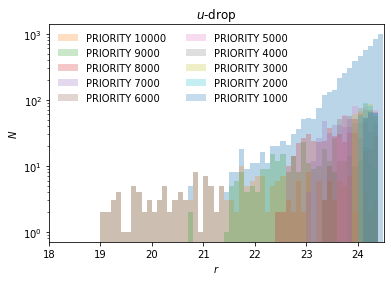

In [52]:
utiers = reduce(0, rlim_udrops, 'r', 'u', area['u'], reprioritise=False, maglim=24.51, levels=10, write=True)

In [129]:
100. * np.mean(utiers['r_err'] == 0.0)

0.2843601895734597

In [130]:
100. * np.mean(utiers['g_err'] == 0.0)

0.3080568720379147

# BX selection

In [53]:
def bx(cat, rmin=19., rmax=24.5):
    # https://arxiv.org/pdf/0903.3951.pdf    
    isin = np.ones(len(cat), dtype=bool)

    cat['u-g'] = cat['u'] - cat['g']
    cat['g-r'] = cat['g'] - cat['r']
    
    # LATIS, https://arxiv.org/pdf/2002.10676.pdf
    # 0.5 < u − g < 2.2 and −0.1 < g − r < 1.0 and u − g > 0.50 + 2.3(g − r − 0.35).
    isin &= cat['u-g'] >  0.0
    isin &= cat['u-g'] <  3.0
    isin &= cat['g-r'] > -0.5
    isin &= cat['g-r'] <  1.0
    isin &= cat['u-g'] >  1.0 + 2.3 * (cat['g-r'] - 0.35)

    # isin &= ((cat['g-r'] < 0.25) & (cat['u-g'] < 1.2)) | (cat['u-g'] >= 1.2)
    # isin &= ((cat['g-r'] < 0.15) & (cat['u-g'] < 1.0)) | (cat['u-g'] >= 1.0)
    
    isin  = isin & (cat['r'] > rmin)
    isin  = isin & (cat['r'] < rmax)
    
    isin  = isin & (~liu_udrops(cat, band='r', magmin=rmin, maglim=rmax))

    # Catch -99 for ill defined magnitudes
    isin = isin & (cat['u'] > 0.0)
    isin = isin & (cat['g'] > 0.0)
    
    return  isin

In [54]:
# not u-drops, by definition.
bx_clauds = clauds[bx(clauds, rmin=19., rmax=24.5)]

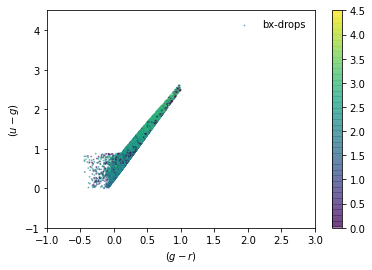

In [191]:
pl.scatter(bx_clauds['g'] - bx_clauds['r'], bx_clauds['u'] - bx_clauds['g'], marker='.', c=bx_clauds['Z_BC03'], alpha=0.5, label='bx-drops', vmin=0.0, vmax=4.5, s=3)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

pl.colorbar()

pl.legend(frameon=False)

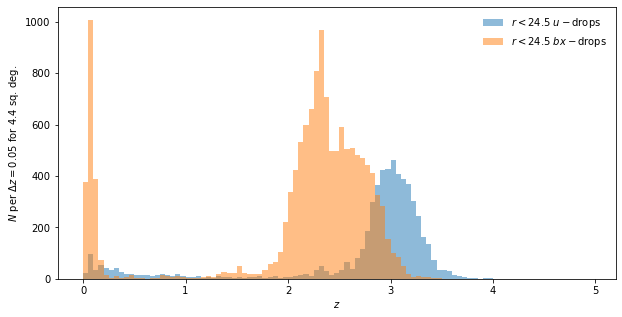

In [56]:
fig, axes = plt.subplots(1, 1, figsize=(10., 5.))
    
dz   = 0.05
bins = np.arange(0.0, 5.0, dz)

axes.hist(rlim_udrops['Z_BC03'], bins=bins, alpha=0.5, label=r'$r<24.5$ $u-$drops')
axes.hist(bx_clauds['Z_BC03'], bins=bins, alpha=0.5, label=r'$r<24.5$ $bx-$drops')

axes.set_xlabel(r'$z$')
axes.set_ylabel(r'$N$ per $\Delta z={:.2f}$ for {:.1f} sq. deg.'.format(dz, area['u']))

axes.legend(frameon=False)

In [57]:
print('Target density of bx-dropouts per sq. deg. is {:.2f}'.format(len(bx_clauds) / area['u']))

Target density of bx-dropouts per sq. deg. is 3018.14


In [58]:
bx_interlopers = bx_clauds[bx_clauds['ZPHOT'] < 0.1]

In [59]:
print('BX interloper percentage of {:.3f}'.format(100. * np.count_nonzero(bx_clauds['ZPHOT'] < 0.1) / len(bx_clauds)))

BX interloper percentage of 11.638


In [60]:
start_id = len(utiers)
start_id

4220

20.0 	 1 	 1444	Adjusting 944 entries.
20.0 	 2 	 500

21.5 	 3 	 466
21.5 	 3 	 466

22.8 	 4 	 638	Adjusting 138 entries.
22.8 	 5 	 500

23.2 	 6 	 1374	Adjusting 874 entries.
23.2 	 7 	 500

23.5 	 8 	 1802	Adjusting 1302 entries.
23.5 	 9 	 500

23.7 	 10 	 1737	Adjusting 1237 entries.
23.7 	 11 	 500

23.8 	 12 	 849	Adjusting 349 entries.
23.8 	 13 	 500

23.9 	 14 	 641	Adjusting 141 entries.
23.9 	 15 	 500

24.0 	 16 	 541	Adjusting 41 entries.
24.0 	 17 	 500

24.1 	 18 	 525	Adjusting 25 entries.
24.1 	 19 	 500


-------------------------

10017 	 13310



     10000 	  113.4 per sq. deg. 	 19.00 	 21.78 	 0.30 	 (0.06 	 0.09 	 2.25) 	 66.20% z < 1.5 contamination
      9000 	  105.7 per sq. deg. 	 20.04 	 22.75 	 0.98 	 (0.08 	 2.01 	 2.49) 	 45.28% z < 1.5 contamination
      8000 	  113.4 per sq. deg. 	 21.64 	 23.36 	 1.23 	 (0.20 	 2.29 	 2.56) 	 26.40% z < 1.5 contamination
      7000 	  113.4 per sq. deg. 	 22.80 	 23.70 	 0.85 	 (2.08 	 2.33 	 2.62) 	 17.20% z < 1.

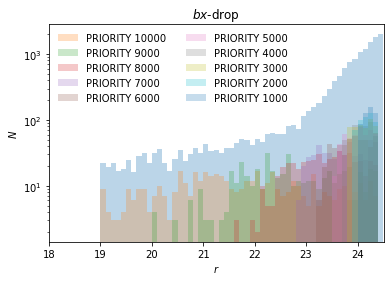

In [69]:
bxtiers = reduce(start_id, bx_clauds, 'r', 'bx', area['u'], levels=10, priority_shift=0, maglim=24.51, reprioritise=False, debug=False, write=True)

In [70]:
bxtiers[bxtiers['PRIORITY'] >= 0]

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [7],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,FUV,NUV,u,uS,g,r,i,z,y,Yv,J,H,Ks,FUV_err,NUV_err,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,MAG_APER_3s_u,MAG_APER_3s_uS,MAG_APER_3s_g,MAG_APER_3s_r,MAG_APER_3s_i,MAG_APER_3s_z,MAG_APER_3s_y,MAG_APER_3s_Yv,MAG_APER_3s_J,MAG_APER_3s_H,MAG_APER_3s_Ks,MAGERR_APER_3s_u,MAGERR_APER_3s_uS,MAGERR_APER_3s_g,MAGERR_APER_3s_r,MAGERR_APER_3s_i,MAGERR_APER_3s_z,MAGERR_APER_3s_y,MAGERR_APER_3s_Yv,MAGERR_APER_3s_J,MAGERR_APER_3s_H,MAGERR_APER_3s_Ks,OFFSET_MAG_2s,OFFSET_MAG_3s,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,Z_BC03,ZPHOT,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,STAR_FORMING,NrK,IRX_NrK,LIR_NrK,SFR_NrK,VMAX_uS,VMAX_g,VMAX_r,VMAX_i,VMAX_Ks,u-g,g-r,PRIORITY,TILEID,SAMPLE,TARGETID,SUBPRIORITY,PMRA,PMDEC,REF_EPOCH,OVERRIDE
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int32,str9,int64,float64,float32,float32,float32,float32
3940590,150.59427387047333,2.7534662436249,9813,"2,7",0,95,True .. True,9.867166e-05,6.907334e-05,4.0,-72.74969,1.4285536,0.29999125,0.017206002497623062,0.00049458025,21.661787,0.99983084,1.032841,1.4687179,1.8145069,-99.0,-99.0,22.693,22.649,22.06,22.034,21.804,21.891,21.791,21.87,21.834,21.786,21.829,-99.0,-99.0,0.002,0.002,0.001,0.001,0.001,0.001,0.003,0.002,0.003,0.003,0.005,22.821491,22.776077,22.169107,22.127043,21.884111,21.963503,21.859617,21.93717,21.895353,21.841795,21.881128,0.0016813278,0.0022602081,0.0008687973,0.0009713173,0.00083732605,0.0014038086,0.0025405884,0.002008438,0.002620697,0.0032596588,0.0049209595,22.77521,22.730316,22.12239,22.079744,21.839033,21.91756,21.812975,21.891344,21.848978,21.795618,21.833424,0.0016384125,0.0022144318,0.0008530617,0.0009522438,0.00082302094,0.0013790131,0.002494812,0.0019741058,0.0025730133,0.0032024384,0.004825592,-0.046242238689587115,0.0,2047.0,-14.815,-14.956,-15.3

In [134]:
100. * np.mean(bxtiers['u_err'] == 0.0)

0.4991514425476689

In [137]:
100. * np.mean(bxtiers['g_err'] == 0.0)

1.8069282220225618

In [138]:
100. * np.mean(bxtiers['r_err'] == 0.0)

1.8268942797244683

# Goldrush g-dropouts

In [103]:
clauds_hsc, area = get_clauds(imaging_bit=0, field='COSMOS')

In [104]:
def gdrop(cat, imin=18., imax=25.5):
    # https://arxiv.org/pdf/0903.3951.pdf    
    isin  = np.ones(len(cat), dtype=bool)

    cat['r-i'] = cat['r'] - cat['i']
    cat['g-r'] = cat['g'] - cat['r']

    # https://arxiv.org/pdf/1704.06004.pdf
    isin &= cat['g-r'] >  1.0
    isin &= cat['r-i'] <  1.0    
    isin &= cat['g-r'] >  1.5 * cat['r-i'] + 0.8
    
    isin  = isin & (cat['i'] > imin)
    isin  = isin & (cat['i'] < imax)
    
    # Catch -99 for ill defined magnitudes
    isin = isin & (cat['g'] > 0.0)
    isin = isin & (cat['r'] > 0.0)
    isin = isin & (cat['i'] > 0.0)
    
    # Exclude where we have u imaging
    isin = isin & (cat['FLAG_FIELD_BINARY'][:,1] == False)
        
    return  isin

In [105]:
clauds_hsc

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [7],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,FUV,NUV,u,uS,g,r,i,z,y,Yv,J,H,Ks,FUV_err,NUV_err,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,MAG_APER_3s_u,MAG_APER_3s_uS,MAG_APER_3s_g,MAG_APER_3s_r,MAG_APER_3s_i,MAG_APER_3s_z,MAG_APER_3s_y,MAG_APER_3s_Yv,MAG_APER_3s_J,MAG_APER_3s_H,MAG_APER_3s_Ks,MAGERR_APER_3s_u,MAGERR_APER_3s_uS,MAGERR_APER_3s_g,MAGERR_APER_3s_r,MAGERR_APER_3s_i,MAGERR_APER_3s_z,MAGERR_APER_3s_y,MAGERR_APER_3s_Yv,MAGERR_APER_3s_J,MAGERR_APER_3s_H,MAGERR_APER_3s_Ks,OFFSET_MAG_2s,OFFSET_MAG_3s,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,Z_BC03,ZPHOT,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,STAR_FORMING,NrK,IRX_NrK,LIR_NrK,SFR_NrK,VMAX_uS,VMAX_g,VMAX_r,VMAX_i,VMAX_Ks
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
5257913,150.9694853174627,2.3761541388796923,9814,"8,5",0,5,True .. False,4.54846e-05,3.6067755e-05,5.1549387,43.939198,1.261042,0.20700502,0.020469196757838648,0.0,27.343435,0.346749,1.5403694,1.7093737,1.8669045,-99.0,-99.0,29.554,28.534,28.733,31.273,28.916,27.481,27.569,-99.025,-99.018,-99.012,-99.007,-99.0,-99.0,1000.0,0.932,0.609,10.844,1.3,0.596,1.348,1000.0,1000.0,1000.0,1000.0,29.728283,28.706102,28.884018,31.405186,29.03308,27.588533,27.671911,-99.0,-99.0,-99.0,-99.0,1000.0,0.9321289,0.6088867,10.84375,1.2998047,0.5957031,1.3476562,1000.0,1000.0,1000.0,1000.0,28.800526,28.179615,29.146652,99.0,30.906359,27.441576,27.824682,-99.0,-99.0,-99.0,-99.0,1000.0,0.8618164,1.1669922,-99.0,10.9453125,0.77978516,2.3222656,1000.0,1000.0,1000.0,1000.0,-0.07645156020172622,0.0,2047.0,-16.375,-16.179,-144.158,-144.435,-144.175,-144.144,-144.382,-144.549,-144.646,-144.677,-144.737,-144.898,-144.662,-99.0,1.2066,0.14,3.4931,11,0.59162,1.42747,0.56187,24,250,1,2.3447,0.9254,4.6743,5.74,1.44,2.3447,2.3447,2,1800000000.0,0.0,0,597321000.0,8.82532,9.73466,7.94053,9.71059,0.252175,-1.11588,-0.5

In [106]:
ilim_gdrops = clauds_hsc[gdrop(clauds_hsc, imax=25.5)]

In [107]:
len(clauds_hsc) / 1.e6

3.696114

In [108]:
len(ilim_gdrops) / 1.e4

1.0171

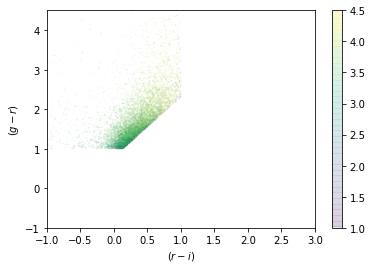

In [109]:
pl.scatter(ilim_gdrops['r'] - ilim_gdrops['i'], ilim_gdrops['g'] - ilim_gdrops['r'], marker='.', c=ilim_gdrops['Z_BC03'], alpha=0.1, label='', vmin=zmax, vmax=4.5, s=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(r-i)$')
pl.ylabel(r'$(g-r)$')

pl.colorbar()

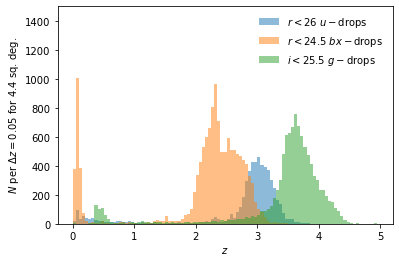

In [110]:
dz   = 0.05
bins = np.arange(0.0, 5.0, dz)

pl.hist(rlim_udrops['Z_BC03'], bins=bins, alpha=0.5, label=r'$r<26$ $u-$drops')
pl.hist(bx_clauds['Z_BC03'], bins=bins, alpha=0.5, label=r'$r<24.5$ $bx-$drops')
pl.hist(ilim_gdrops['Z_BC03'], bins=bins, alpha=0.5, label=r'$i<25.5 \ g-$drops')

pl.ylim(0.0, 1.5e3)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$ per $\Delta z={:.2f}$ for {:.1f} sq. deg.'.format(dz, area['u']))

pl.legend(frameon=False)

In [111]:
print('Target density of g-dropouts per sq. deg. is {:.2f}'.format(len(ilim_gdrops) / area['g']))

Target density of g-dropouts per sq. deg. is 1297.32


In [112]:
print('g-drop interloper percentage of {:.3f}'.format(100. * np.count_nonzero(ilim_gdrops['Z_BC03'] < 1.0) / len(ilim_gdrops)))

g-drop interloper percentage of 5.113


In [113]:
start_id = 1 + bxtiers['TARGETID'].max()
start_id

14237

<ipython-input-36-0d6a8ca5ed7e>:20: RuntimeWarning: divide by zero encountered in true_divide
  magsampling                = 1. / magsampling


20.2 	 1 	 157
20.2 	 1 	 157

23.3 	 2 	 386
23.3 	 2 	 386

23.9 	 3 	 1102	Adjusting 102 entries.
23.9 	 4 	 1000

24.2 	 5 	 1221	Adjusting 221 entries.
24.2 	 6 	 1000

24.4 	 7 	 1063	Adjusting 63 entries.
24.4 	 8 	 1000

24.5 	 9 	 939
24.5 	 9 	 939

24.7 	 10 	 938
24.7 	 10 	 938

24.8 	 11 	 693
24.8 	 11 	 693

24.9 	 12 	 562
24.9 	 12 	 562

25.0 	 13 	 401
25.0 	 13 	 401


-------------------------

7462 	 10171



     10000 	  20.0 per sq. deg. 	 18.04 	 22.93 	 2.37 	 (0.41 	 3.43 	 3.84) 	 42.04% z < 1.5 contamination
      9000 	  49.2 per sq. deg. 	 21.64 	 24.06 	 2.63 	 (3.36 	 3.57 	 3.84) 	 17.36% z < 1.5 contamination
      8000 	  127.6 per sq. deg. 	 23.34 	 24.54 	 3.17 	 (3.41 	 3.57 	 3.83) 	 12.20% z < 1.5 contamination
      7000 	  127.6 per sq. deg. 	 23.91 	 24.76 	 3.19 	 (3.38 	 3.56 	 3.83) 	 11.40% z < 1.5 contamination
      6000 	  127.6 per sq. deg. 	 24.21 	 24.88 	 3.22 	 (3.37 	 3.57 	 3.84) 	 10.90% z < 1.5 contamination
      5000 	  11

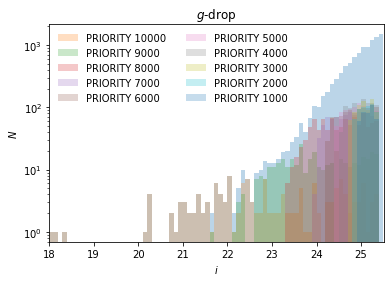

In [115]:
gtiers = reduce(start_id, ilim_gdrops, 'i', 'g', area['g'], max_inpriority=1000, priority_shift=0, maglim=25.51, reprioritise=False, levels=10, debug=False, write=True)

In [101]:
len(gtiers[gtiers['PRIORITY'] >= 0])

6804

In [139]:
100. * np.mean(gtiers['u_err'] == 0.0)

0.0

In [140]:
100. * np.mean(gtiers['g_err'] == 0.0)

0.02680246582685607

In [141]:
100. * np.mean(gtiers['r_err'] == 0.0)

0.04020369874028411

In [143]:
100. * np.mean(gtiers['i_err'] == 0.0)

0.013401232913428035

Text(0.5, 1.0, 'Clauds COSMOS: (150.1388, 2.2112)')

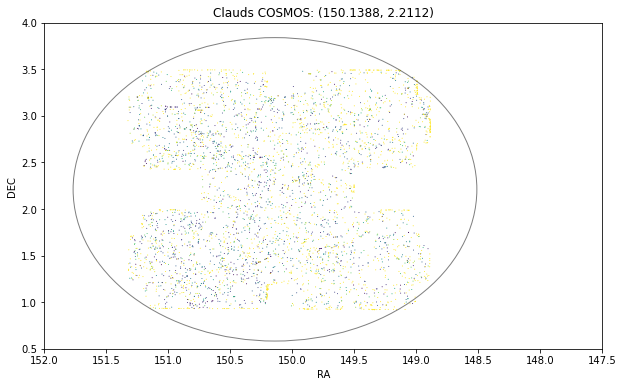

In [98]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 6)) 
im       = pl.scatter(utiers['RA'], utiers['DEC'], c=utiers['u_err'], marker='.', s=4, lw=0.0, vmin=0.0, vmax=.25)

for ind in tileids:    
    circles(cra, cdec, trad, c='k', fc="None", alpha=0.5)
    
    break
    
ax.set_xlim(152., 147.5)
ax.set_ylim( 0.5,   4.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

# cax      = fig.add_axes([0.15, 0.2, 0.2, 0.05])
# fig.colorbar(im, cax=cax, orientation='horizontal')

ax.set_title('Clauds COSMOS: ({:.4f}, {:.4f})'.format(cra, cdec))

Text(0.5, 1.0, 'Clauds COSMOS: (150.1388, 2.2112)')

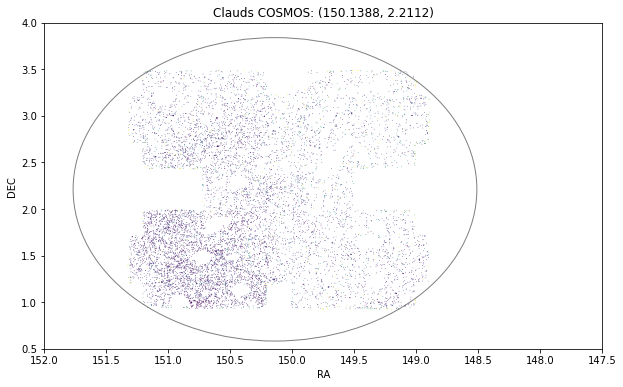

In [97]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 6)) 
im       = pl.scatter(bxtiers['RA'], bxtiers['DEC'], c=bxtiers['u_err'], marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25)

for ind in tileids:    
    circles(cra, cdec, trad, c='k', fc="None", alpha=0.5)
    
    break
    
ax.set_xlim(152., 147.5)
ax.set_ylim( 0.5,   4.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

ax.set_title('Clauds COSMOS: ({:.4f}, {:.4f})'.format(cra, cdec))

Text(0.5, 1.0, 'Clauds COSMOS: (150.1388, 2.2112)')

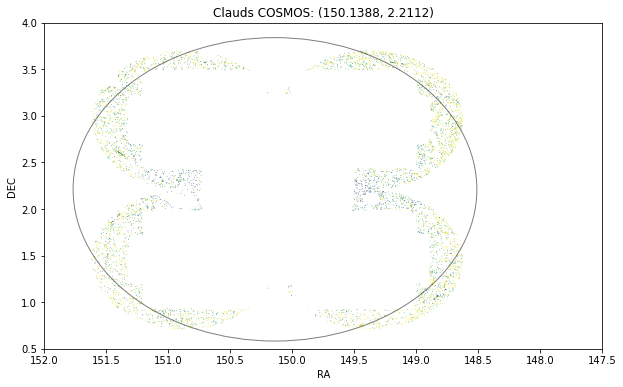

In [102]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 6)) 
im       = pl.scatter(gtiers['RA'], gtiers['DEC'], c=gtiers['g_err'], marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25)

for ind in tileids:    
    circles(cra, cdec, trad, c='k', fc="None", alpha=0.5)
    
    break
    
ax.set_xlim(152., 147.5)
ax.set_ylim( 0.5,   4.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

ax.set_title('Clauds COSMOS: ({:.4f}, {:.4f})'.format(cra, cdec))

# Done.